In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense

In [2]:
data = pd.read_csv(r"C:\Users\himan\Desktop\7th GAN\DATASETS\GuwahatiCovidcsv.csv")
data

,From Date,PM2.5,NO2,Ozone,RH,WS,WD,SR,BP,RF,AT
0,18-02-2019 00:00,58.04,6.40,15.73,NaN,1.86,229.44,0.22,1002.19,0.00,20.87
1,18-02-2019 01:00,60.00,6.08,18.36,NaN,1.54,217.20,1.46,956.00,0.24,18.92
2,18-02-2019 02:00,55.50,6.71,34.54,NaN,0.66,197.21,NaN,1001.60,0.00,18.33
3,18-02-2019 03:00,66.56,7.00,31.85,NaN,0.61,206.44,NaN,1001.41,0.00,17.63
4,18-02-2019 04:00,67.08,9.45,24.07,NaN,0.54,230.53,NaN,980.67,0.00,16.61
...,...,...,...,...,...,...,...,...,...,...,...
33062,30-12-2022 20:00,295.72,2.62,22.82,NaN,0.31,168.12,NaN,1009.22,0.00,15.96
33063,30-12-2022 21:00,362.60,2.62,5.66,NaN,0.69,132.27,11.17,967.18,0.48,14.93
33064,30-12-2022 22:00,277.86,2.46,22.64,NaN,0.36,173.64,NaN,1009.11,0.00,15.22
33065,30-12-2022 23:00,380.00,2.47,7.07,NaN,0.82,163.19,9.57,912.74,1.09,13.45


In [3]:
data = data.drop(columns=[ 'From Date'])

In [4]:
# Replaceing NaN values with 0
data.fillna(0, inplace=True)

In [5]:
#  dataset has columns for features and a target variable

feature_columns = ['PM2.5'	,'NO2'	,'Ozone'	,'RH'	,'WS'	,'WD'	,'SR'	,'BP'	,'RF'	,'AT']
target_column = 'PM2.5'

In [6]:
# Splitting the dataset into features and target variable
X = data[feature_columns].values
y = data[target_column].values

In [7]:
# Normalizing the feature values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# sliding window parameters
window_size = 5  # Number of past time steps considered
output_size = 10  # Number of steps ahead used to predict pollutant concentration

In [9]:
# Create 3D dataset using sliding window technique
def create_dataset(X, y, window_size, output_size):
    X_windowed = []
    y_windowed = []
    for i in range(len(X) - window_size - output_size + 1):
        X_windowed.append(X[i:i+window_size])
        y_windowed.append(y[i+window_size:i+window_size+output_size])
    return np.array(X_windowed), np.array(y_windowed)

X_windowed, y_windowed = create_dataset(X_scaled, y, window_size, output_size)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_windowed, test_size=0.2, random_state=42)

In [11]:
# Build the bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dense(output_size))  # Output layer with 'output_size' neurons for multi-step ahead prediction
model.compile(optimizer='adam', loss='mse')

In [12]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100

827/827 [==============================] - 15s 10ms/step - loss: 4901.1929 - val_loss: 3899.4917
Epoch 2/100
827/827 [==============================] - 7s 8ms/step - loss: 4205.7666 - val_loss: 3859.0854
Epoch 3/100
827/827 [==============================] - 7s 8ms/step - loss: 3197.2244 - val_loss: 2244.8010
Epoch 4/100
827/827 [==============================] - 7s 8ms/step - loss: 2395.7153 - val_loss: 2026.1096
Epoch 5/100
827/827 [==============================] - 7s 8ms/step - loss: 2219.4971 - val_loss: 1895.9534
Epoch 6/100
827/827 [==============================] - 7s 8ms/step - loss: 2116.7085 - val_loss: 1853.8488
Epoch 7/100
827/827 [==============================] - 7s 9ms/step - loss: 2007.1737 - val_loss: 1732.0146
Epoch 8/100
827/827 [==============================] - 7s 9ms/step - loss: 1899.4630 - val_loss: 1638.8856
Epoch 9/100
827/827 [==============================] - 7s 9ms/step - loss: 1826.1969 - val_loss: 1573.6276
Epoch 10/100
827/827 [============

In [13]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

207/207 [==============================] - 1s 5ms/step - loss: 1222.2380
Test Loss: 1222.238037109375
207/207 [==============================] - 6s 6ms/step


In [14]:
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

# Calculate Fraction of predictions with a factor of 2 (FAC2)
def fac2(y_true, y_pred):
    within_factor = np.abs(y_true / y_pred) <= 2
    return np.mean(within_factor)

# Calculate Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Calculate Correlation Coefficient (r)
r = np.corrcoef(np.ravel(y_test), np.ravel(predictions))[0, 1]

# Calculate Mean Gross Error (MGE)
mge = np.mean(np.abs(y_test - predictions))

# Calculate Mean Bias (MB)
mb = np.mean(y_test - predictions)

# Calculate Coefficient of Efficiency (COE)
coe = 1 - (np.sum((y_test - predictions) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

# Calculate Coefficient of Determination (R2 score)
r2 = r2_score(y_test, predictions)

# Print the evaluation metrics
print(f'Fraction of predictions with a factor of 2 (FAC2): {fac2(y_test, predictions)}')
print(f'Root Mean Square Error (RMSE): {rmse}')
print(f'Correlation Coefficient (r): {r}')
print(f'Mean Gross Error (MGE): {mge}')
print(f'Mean Bias (MB): {mb}')
print(f'Coefficient of Efficiency (COE): {coe}')
print(f'Coefficient of Determination (R2 score): {r2}')

Fraction of predictions with a factor of 2 (FAC2): 0.9531538345182272
Root Mean Square Error (RMSE): 34.960517495005625
Correlation Coefficient (r): 0.8288309270413434
Mean Gross Error (MGE): 17.818625372217817
Mean Bias (MB): 0.656137278408601
Coefficient of Efficiency (COE): 0.6857670793410017
Coefficient of Determination (R2 score): 0.684800583903612


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

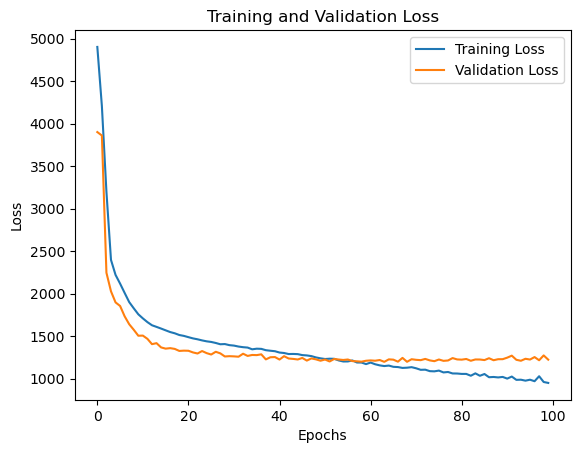

In [16]:

# Plot training loss vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


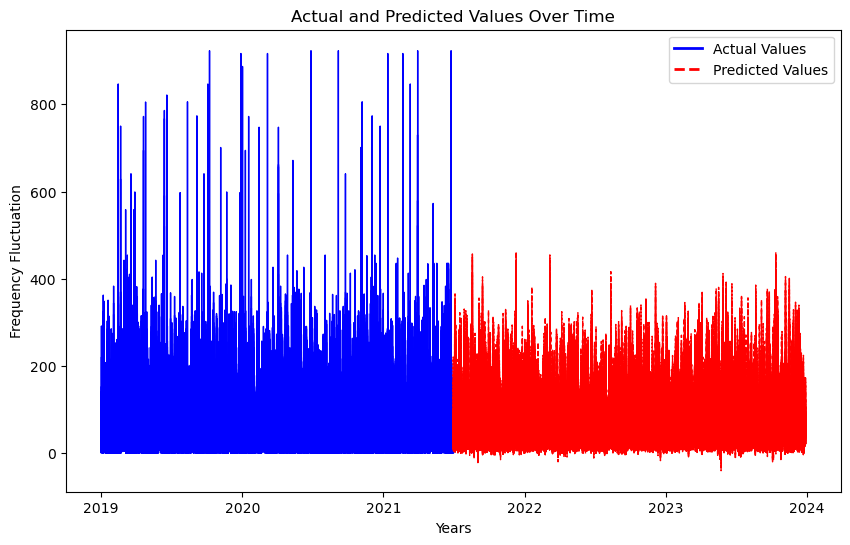

In [24]:
# Line plot of actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(y_test)), y_test, label='Actual Values', color='blue', linewidth=1)
plt.plot(range(len(y_test)-20, len(y_test)+len(predictions)-20), predictions, label='Predicted Values', color='red', linestyle='--', linewidth=1)
plt.title('Actual and Predicted Values Over Time')

# Adjusting x-axis to represent years
plt.xlabel('Years')
plt.ylabel('Frequency Fluctuation')

# Assuming y_test covers 80 data points (4 years) and predictions 20 data points (1 year)
# Adjust x-ticks based on total data points
total_points = len(y_test) + len(predictions)
plt.xticks(ticks=np.linspace(0, total_points, 6), labels=['2019', '2020', '2021', '2022', '2023', '2024'])

# Create custom legend handles
actual_handle = plt.Line2D([], [], color='blue', linewidth=2, label='Actual Values')
predicted_handle = plt.Line2D([], [], color='red', linestyle='--', linewidth=2, label='Predicted Values')

# Add the legend with custom handles
plt.legend(handles=[actual_handle, predicted_handle])
plt.show()

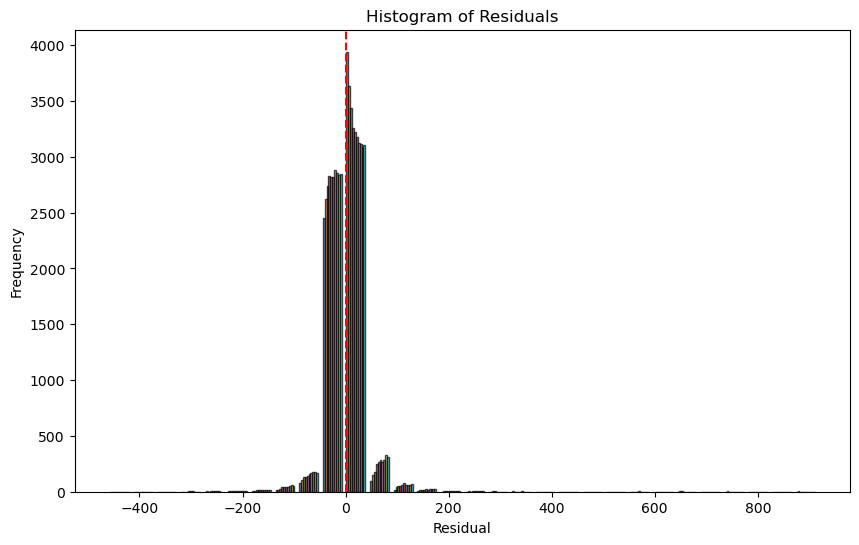

In [23]:
# Plotting the histogram of residuals
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--')
plt.show()